In [27]:
!pip install pandas


In [37]:
import pandas as pd 

In [1]:
import pandas as pd
churn_model = pd.read_csv('Churn_Modelling.csv')
fraud_data = pd.read_csv('creditcard_2023 fruad detection set.csv')
etf_data = pd.read_csv('etf_data.csv')
personal_data = pd.read_csv('Finance_data_personal.csv')
macro_data = pd.read_csv('Macroeconomic Data.csv')

In [ ]:
#Preview for each Dataset 
print(churn_model.head())
print(fraud_data.head())
print(etf_data.head())
print(personal_data.head())
print(macro_data.head())


In [59]:
#Check each dataset for missing values 
print(fraud_data.isnull().sum())
print(etf_data.isnull().sum())
print(macro_data.isnull().sum())
print(churn_model.isnull().sum())
print(personal_data.isnull().sum())

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64
Date                  0
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Day                   0
Weekday               0
Week                  0
Month                 0
Year                  0
daily_returns         1
cumulative_returns    1
dtype: int64
DATE                              0
UNRATE(%)                         0
CONSUMER CONF INDEX               0
PPI-CONST MAT.                    0
CPIALLITEMS                       0
INFLATION(%)                      0
MORTGAGE INT. MONTHLY AVG(%)      0
MED HOUSEHOLD INCOME             17
CO

In [119]:
#Convert each 'Date' column to a Date Format 
etf_data['Date'] = pd.to_datetime(etf_data['Date'], errors = 'coerce')
macro_data['DATE'] = pd.to_datetime(macro_data['DATE'], errors = 'coerce')
                                    

In [121]:
#Matching the Date Range between the etf_data & macro_data 

start_date = max(etf_data['Date'].min(), macro_data['DATE'].min())
end_date = min(etf_data['Date'].max(), macro_data['DATE'].max())

#filtering the datasets so it matches eachothers date ranges 
etf_data = etf_data[(etf_data['Date'] >= start_date) & (etf_data['Date'] <= end_date)]
macro_data = macro_data[(macro_data['DATE'] >= start_date) & (macro_data['DATE'] <= end_date)]


In [123]:
#obtaining the moving averages over the span of a week and a month (7 & 30 days)
etf_data.loc[:, '7_day_average'] = etf_data['Close'].rolling(window=7).mean()
etf_data.loc[:, '30_day_average'] = etf_data['Close'].rolling(window=7).mean()



In [136]:
#volatility calculations - std over the moving averages 
etf_data['volatility'] = etf_data['7_day_average'].std()
etf_data['volatility'] = etf_data['30_day_average'].std()


In [127]:
#capturing the changes in prices 
etf_data['price_changes'] = etf_data['Close'].diff(periods = 7)
etf_data['price_changes'] = etf_data['Close'].diff(periods = 30)

In [129]:
#Daily and Cumulative returns 
etf_data['daily_returns'] = etf_data['Close'].pct_change()
etf_data['cumulative_returns'] = (1 + etf_data['daily_returns']).cumprod()

In [134]:
#Rolling average for unemployment 3 & 12 months
macro_data['UNRATE_3M_avg'] = macro_data['UNRATE(%)'].rolling(window=3).mean()
macro_data['UNRATE_12M_avg'] = macro_data['UNRATE(%)'].rolling(window=12).mean()


In [3]:
# Lagged Version of Unemployment Rate for a previous time to shift to the model in the current time 
macro_data['UNRATE_LAG_1'] = macro_data['UNRATE(%)'].shift(1)
macro_data['UNRATE_LAG_3'] = macro_data['UNRATE(%)'].shift(3)


In [21]:
#Year to Year Changes 
macro_data['UNRATE_YoY_Change'] = macro_data['UNRATE(%)'].pct_change(periods=12) * 100

In [27]:
#Multiplacation of related columns to see combined outcomes 
macro_data['UNRATE_MORTAGE'] = macro_data['UNRATE(%)'] * macro_data['MORTGAGE INT. MONTHLY AVG(%)']

In [73]:
#Merging of the dates 
merged_data = pd.merge(etf_data, macro_data, left_on ='Date', right_on='DATE', how ='inner')

In [65]:
churn_model['HasCrCard'] = churn_model['HasCrCard'].astype('category') #convert categorical columns 
churn_model['Tenure_Buckets'] = pd.cut(churn_model['Tenure'], bins=[0, 5, 10], labels=['Short', 'Long'])  # Bucket tenure


In [120]:
bins = [0, 18, 25, 35, 50, 65, 100]  # Define the age ranges
labels = ['0-17', '18-25', '26-35', '36-50', '51-65', '65+']  # Define labels
personal_data['age_bucket'] = pd.cut(personal_data['age'], bins=bins, labels=labels)


In [138]:
grouping_columns = ['age', 'gender', 'Investment_Avenues']  # Replace with your grouping columns
personal_summary = personal_data.groupby(grouping_columns).agg({
    'Mutual_Funds': 'mean',
    'Equity_Market': 'mean',
    'Fixed_Deposits': 'mean',
    'PPF': 'mean',
    'Gold': 'mean',
})


In [128]:
personal_summary = personal_summary.reset_index() #resembles df more 

In [148]:
print(personal_data[['age', 'age_bucket']].head()) #verifying age buckets groups


   age age_bucket
0   34      26-35
1   23      18-25
2   30      26-35
3   22      18-25
4   24      18-25


In [286]:
# Normalization/Scaling for numerical columns so values are only between 0-1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
personal_data[['Mutual_Funds', 'Equity_Market', 'Fixed_Deposits']] = scaler.fit_transform(personal_data[['Mutual_Funds', 'Equity_Market', 'Fixed_Deposits']])


In [288]:
merged_data = pd.merge(etf_data, macro_data, left_on='Date', right_on='DATE', how='inner')
print(churn_model.columns)
print(merged_data.columns)

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Tenure_Buckets', 'merge_key'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Weekday',
       'Week', 'Month', 'Year', 'DATE', 'UNRATE(%)', 'CONSUMER CONF INDEX',
       'PPI-CONST MAT.', 'CPIALLITEMS', 'INFLATION(%)',
       'MORTGAGE INT. MONTHLY AVG(%)', 'MED HOUSEHOLD INCOME',
       'CORP. BOND YIELD(%)', 'MONTHLY HOME SUPPLY',
       '% SHARE OF WORKING POPULATION', 'GDP PER CAPITA', 'QUARTERLY REAL GDP',
       'QUARTERLY GDP GROWTH RATE (%)', 'CSUSHPISA', 'UNRATE_LAG_1',
       'UNRATE_LAG_3', 'UNRATE_YoY_Change', 'UNRATE_MORTAGE'],
      dtype='object')


In [296]:
churn_model['RowNumber'] = range(1, len(churn_model) + 1)


In [300]:
#merging based on a custom key since no key primary columns 
churn_model['merge_key'] = churn_model['RowNumber']
merged_data['merge_key'] = range(1, len(merged_data) + 1) # Add a similar range-based key


In [304]:
print(merged_data.columns)
print(churn_model.columns)
#finding the common columns 
common_columns = set(merged_data.columns).intersection(set(churn_model.columns))
print("Common Columns:", common_columns)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Weekday',
       'Week', 'Month', 'Year', 'DATE', 'UNRATE(%)', 'CONSUMER CONF INDEX',
       'PPI-CONST MAT.', 'CPIALLITEMS', 'INFLATION(%)',
       'MORTGAGE INT. MONTHLY AVG(%)', 'MED HOUSEHOLD INCOME',
       'CORP. BOND YIELD(%)', 'MONTHLY HOME SUPPLY',
       '% SHARE OF WORKING POPULATION', 'GDP PER CAPITA', 'QUARTERLY REAL GDP',
       'QUARTERLY GDP GROWTH RATE (%)', 'CSUSHPISA', 'UNRATE_LAG_1',
       'UNRATE_LAG_3', 'UNRATE_YoY_Change', 'UNRATE_MORTAGE', 'merge_key'],
      dtype='object')
Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Tenure_Buckets', 'merge_key', 'RowNumber'],
      dtype='object')
Common Columns: {'merge_key'}


In [302]:
# Keep only the original columns and drop _x and _y columns
columns_to_drop = [col for col in merged_data.columns if '_x' in col or '_y' in col]
merged_data = merged_data.drop(columns=columns_to_drop)



In [308]:
#checking the merge
final_merged_data = pd.merge(merged_data, churn_model, on='merge_key', how='inner')
print(final_merged_data.head())
print(final_merged_data.columns)


        Date       Open       High        Low      Close    Volume  Day  \
0   1/7/2002  77.031481  77.221279  76.285382  76.435913  13106500    7   
1   1/8/2002  76.435950  76.612655  75.899282  76.259239  12683700    8   
2   1/9/2002  76.363917  77.083836  75.486920  75.637451  16610300    9   
3  1/10/2002  75.715970  76.147920  75.460726  75.971214  12823400   10   
4  1/11/2002  76.056353  76.102166  75.068097  75.225174  13708400   11   

   Weekday  Week  Month  ...  Gender   Age  Tenure    Balance  NumOfProducts  \
0        0     2      1  ...  Female  42.0       2       0.00              1   
1        1     2      1  ...  Female  41.0       1   83807.86              1   
2        2     2      1  ...  Female  42.0       8  159660.80              3   
3        3     2      1  ...  Female  39.0       1       0.00              2   
4        4     2      1  ...  Female  43.0       2  125510.82              1   

   IsActiveMember  EstimatedSalary  Exited  Tenure_Buckets  RowNumbe

In [439]:
# 1. Start with merged_data
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')

# 2. Create a final copy for processing
final_merged_data = merged_data.copy()

# 3. Clean and process numeric columns
for col in ['Balance', 'EstimatedSalary', 'GDP PER CAPITA']:
    final_merged_data[col] = pd.to_numeric(final_merged_data[col], errors='coerce')
final_merged_data.dropna(subset=['Balance', 'EstimatedSalary', 'GDP PER CAPITA'], inplace=True)

# 4. Apply feature engineering (scaling or encoding)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_merged_data[['Balance', 'EstimatedSalary', 'GDP PER CAPITA']])
final_merged_data[['Balance', 'EstimatedSalary', 'GDP PER CAPITA']] = scaled_features




In [443]:
print(final_merged_data.dtypes)


Date                             datetime64[ns]
Open                                    float64
High                                    float64
Low                                     float64
Close                                   float64
Volume                                    int64
Day                                       int64
Weekday                                   int64
Week                                      int64
Month                                     int64
Year                                      int64
UNRATE(%)                               float64
CONSUMER CONF INDEX                     float64
PPI-CONST MAT.                          float64
CPIALLITEMS                             float64
INFLATION(%)                            float64
MORTGAGE INT. MONTHLY AVG(%)            float64
MED HOUSEHOLD INCOME                    float64
CORP. BOND YIELD(%)                     float64
MONTHLY HOME SUPPLY                     float64
% SHARE OF WORKING POPULATION           

In [445]:
#scaling feautr
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_merged_data[['Balance', 'EstimatedSalary', 'GDP PER CAPITA']])
final_merged_data[['Balance', 'EstimatedSalary', 'GDP PER CAPITA']] = scaled_features


In [447]:
final_merged_data['Date'] = pd.to_datetime(final_merged_data['Date'], errors='coerce')
print(final_merged_data['Date'].head())
print(final_merged_data['Date'].dtypes)


0   2002-01-07
1   2002-01-08
2   2002-01-09
3   2002-01-10
4   2002-01-11
Name: Date, dtype: datetime64[ns]
datetime64[ns]


In [397]:
#Splitting the data into features and target variable 
from sklearn.model_selection import train_test_split 

#(x) and target variable (y)
X = final_merged_data.drop(columns=['Exited'])
y = final_merged_data['Exited']

#Split the data into training and testing set (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Features Shape:", X_train.shape)
print("Testing Features Shape:", X_test.shape)
print("Training Target Shape:", y_train.shape)
print("Testing Target Shape:", y_test.shape)

Training Features Shape: (121, 42)
Testing Features Shape: (31, 42)
Training Target Shape: (121,)
Testing Target Shape: (31,)


In [506]:
# Check for non-numeric columns in X_train
non_numeric_cols = X_train.select_dtypes(include=['object', 'datetime','category']).columns
print("Non-numeric columns in X_train:", non_numeric_cols)
if 'Date' in X_train.columns:
    X_train['Year'] = X_train['Date'].dt.year
    X_train['Month'] = X_train['Date'].dt.month
    X_train['Day'] = X_train['Date'].dt.day
    X_train = X_train.drop(columns=['Date'])
if 'Date' in X_test.columns:
    X_test['Year'] = X_test['Date'].dt.year
    X_test['Month'] = X_test['Date'].dt.month
    X_test['Day'] = X_test['Date'].dt.day
    X_test = X_test.drop(columns=['Date'])




Non-numeric columns in X_train: Index(['Tenure_Buckets'], dtype='object')


In [524]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encode categorical columns
encoded_data = pd.get_dummies(final_merged_data, columns=non_numeric_cols, drop_first=True)

# Drop non-predictive columns
X = final_merged_data.drop(columns=['Date', 'merge_key', 'RowNumber', 'Short', 'Long'], errors='ignore')

# Define target variable
y = final_merged_data['Exited']  # Replace 'Exited' with your target variable

# Align train and test datasets
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(X_train.dtypes)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)


X_train shape: (121, 42)
X_test shape: (31, 42)
y_train shape: (121,)
y_test shape: (31,)
% SHARE OF WORKING POPULATION     float64
Age                               float64
Balance                           float64
CONSUMER CONF INDEX               float64
CORP. BOND YIELD(%)               float64
CPIALLITEMS                       float64
CSUSHPISA                         float64
Close                             float64
CreditScore                         int64
DATE                                int64
Day                                 int32
EstimatedSalary                   float64
GDP PER CAPITA                    float64
Gender_Male                          bool
Geography_Germany                    bool
Geography_Spain                      bool
High                              float64
INFLATION(%)                      float64
IsActiveMember                    float64
Low                               float64
MED HOUSEHOLD INCOME              float64
MONTHLY HOME SUPPLY         

In [560]:
X_train = X_train.drop(columns=['Short'], errors='ignore')
X_test = X_test.drop(columns=['Short'], errors='ignore')


In [562]:
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns:", non_numeric_cols)
X_train = pd.get_dummies(X_train, columns=non_numeric_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=non_numeric_cols, drop_first=True)
X_train, X_test = X_train.align(X_test, join='outer', axis=1, fill_value=0)
from sklearn.preprocessing import LabelEncoder

for col in non_numeric_cols:
    encoder = LabelEncoder()
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])
print(X_train.dtypes)
print(X_test.dtypes)


Non-numeric columns: Index([], dtype='object')
% SHARE OF WORKING POPULATION    float64
Age                              float64
Balance                          float64
CONSUMER CONF INDEX              float64
CORP. BOND YIELD(%)              float64
CPIALLITEMS                      float64
CSUSHPISA                        float64
Close                            float64
CreditScore                        int64
DATE                               int64
Day                                int32
EstimatedSalary                  float64
GDP PER CAPITA                   float64
Gender_Male                         bool
Geography_Germany                   bool
Geography_Spain                     bool
High                             float64
INFLATION(%)                     float64
IsActiveMember                   float64
Low                              float64
MED HOUSEHOLD INCOME             float64
MONTHLY HOME SUPPLY              float64
MORTGAGE INT. MONTHLY AVG(%)     float64
Month     

In [568]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [582]:
print(X_train.isnull().sum())
from sklearn.impute import SimpleImputer

# Impute missing values with the mean (for numerical columns)
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)



% SHARE OF WORKING POPULATION    0
Age                              0
Balance                          0
CONSUMER CONF INDEX              0
CORP. BOND YIELD(%)              0
CPIALLITEMS                      0
CSUSHPISA                        0
Close                            0
CreditScore                      0
DATE                             0
Day                              0
EstimatedSalary                  0
GDP PER CAPITA                   0
Gender_Male                      0
Geography_Germany                0
Geography_Spain                  0
High                             0
INFLATION(%)                     0
IsActiveMember                   0
Low                              0
MED HOUSEHOLD INCOME             0
MONTHLY HOME SUPPLY              0
MORTGAGE INT. MONTHLY AVG(%)     0
Month                            0
NumOfProducts                    0
Open                             0
PPI-CONST MAT.                   0
QUARTERLY GDP GROWTH RATE (%)    0
QUARTERLY REAL GDP  

In [598]:
print(X_test.dtypes)
numeric_columns = X_test.select_dtypes(include=['number']).columns
non_numeric_columns = X_test.select_dtypes(exclude=['number']).columns
X_test_numeric = X_test[numeric_columns]

# Impute missing numeric data
imputer = SimpleImputer(strategy='mean')  # Mean imputation for numeric columns
X_test_numeric = pd.DataFrame(imputer.fit_transform(X_test_numeric), columns=numeric_columns)

X_test_non_numeric = X_test[non_numeric_columns]

imputer = SimpleImputer(strategy='most_frequent')  # Mode imputation for non-numeric columns
X_test_non_numeric = pd.DataFrame(imputer.fit_transform(X_test_non_numeric), columns=non_numeric_columns)

X_test = pd.concat([X_test_numeric, X_test_non_numeric], axis=1)
print(X_test.isnull().sum().sum())  # Should return 0


% SHARE OF WORKING POPULATION    float64
Age                              float64
Balance                          float64
CONSUMER CONF INDEX              float64
CORP. BOND YIELD(%)              float64
CPIALLITEMS                      float64
CSUSHPISA                        float64
Close                            float64
CreditScore                      float64
Day                              float64
EstimatedSalary                  float64
GDP PER CAPITA                   float64
High                             float64
INFLATION(%)                     float64
IsActiveMember                   float64
Low                              float64
MED HOUSEHOLD INCOME             float64
MONTHLY HOME SUPPLY              float64
MORTGAGE INT. MONTHLY AVG(%)     float64
Month                            float64
NumOfProducts                    float64
Open                             float64
PPI-CONST MAT.                   float64
QUARTERLY GDP GROWTH RATE (%)    float64
QUARTERLY REAL G

In [580]:
print(X_train.isnull().sum().sum())  # Should return 0
print(X_test.isnull().sum().sum())  # Should return 0


0
3


In [602]:
from sklearn.linear_model import LogisticRegression

# Initialize and train the model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

In [615]:
# Align columns in X_train and X_test
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(X_train.columns.equals(X_test.columns))  # Should return True


True


In [619]:
non_numeric_cols = X_test.select_dtypes(include=['object']).columns
print("Non-numeric columns in X_test:", non_numeric_cols)


Non-numeric columns in X_test: Index(['DATE', 'Gender_Male', 'Geography_Germany', 'Geography_Spain',
       'Tenure_Buckets_Long'],
      dtype='object')


In [1]:
X_test = X_test.drop(columns=['DATE'], errors='ignore')
# Verify that all columns are numeric



NameError: name 'X_test' is not defined

In [631]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [633]:
y_pred = model.predict(X_test)


In [635]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.8064516129032258

Confusion Matrix:
[[24  2]
 [ 4  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89        26
           1       0.33      0.20      0.25         5

    accuracy                           0.81        31
   macro avg       0.60      0.56      0.57        31
weighted avg       0.77      0.81      0.79        31



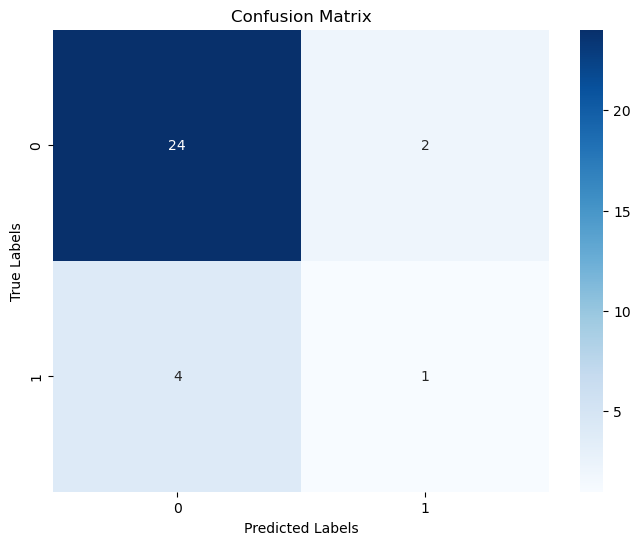

In [638]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


                          Feature    Importance
1                             Age  5.142374e-02
6                       CSUSHPISA  3.838711e-02
3             CONSUMER CONF INDEX  1.590199e-02
39                           Year  1.121947e-02
35              UNRATE_YoY_Change  1.000370e-02
10                            Day  6.178824e-03
8                     CreditScore  3.298899e-03
38                        Weekday  2.397765e-03
25                           Open  2.320305e-03
33                   UNRATE_LAG_3  2.311165e-03
19                            Low  2.039693e-03
34                 UNRATE_MORTAGE  2.038962e-03
32                   UNRATE_LAG_1  1.971982e-03
30                         Tenure  1.942444e-03
7                           Close  1.898535e-03
18                 IsActiveMember  1.707280e-03
26                 PPI-CONST MAT.  1.455760e-03
2                         Balance  1.414984e-03
28             QUARTERLY REAL GDP  1.319474e-03
17                   INFLATION(%)  1.234

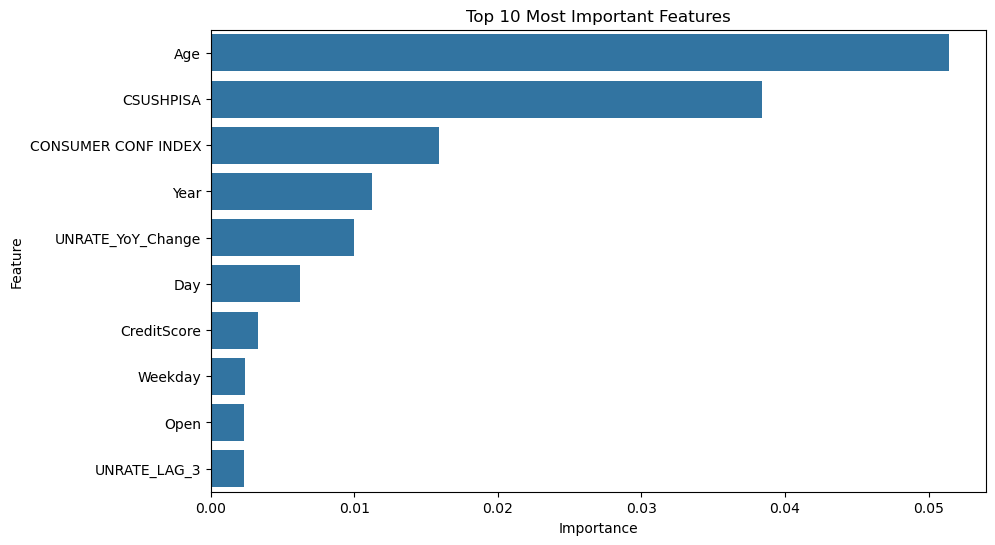

In [642]:
import numpy as np

# Display feature importance
feature_importance = np.abs(model.coef_[0])
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance}).sort_values(by='Importance', ascending=False)

print(importance_df)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Most Important Features')
plt.show()


In [647]:
# Add predictions to your test set
X_test['Actual'] = y_test
X_test['Predicted'] = y_pred

# Find misclassified samples
misclassified = X_test[X_test['Actual'] != X_test['Predicted']]
print("Misclassified samples:")
print(misclassified.head())

# Analyze patterns in misclassifications



Misclassified samples:
    % SHARE OF WORKING POPULATION   Age   Balance  CONSUMER CONF INDEX  \
5                       65.086278  35.0  0.865061                 84.8   
12                      65.880715  33.0  1.194374                107.1   
17                      67.262938  39.0 -1.204738                104.7   
22                      67.170762  45.0  0.839071                 53.1   
25                      65.086278  48.0  2.202232                 92.6   

    CORP. BOND YIELD(%)  CPIALLITEMS  CSUSHPISA       Close  CreditScore  \
5                  2.25   109.662176    143.192  301.817902        579.0   
12                 3.86   101.829405    175.147  165.287125        605.0   
17                 5.89    85.605674    200.876   90.007561        591.0   
22                 5.13    91.119624    168.663   66.318665        656.0   
25                 2.14   109.317475    145.059  300.217957        584.0   

    DATE  ...  UNRATE_MORTAGE  UNRATE_YoY_Change       Volume Week Weekday 

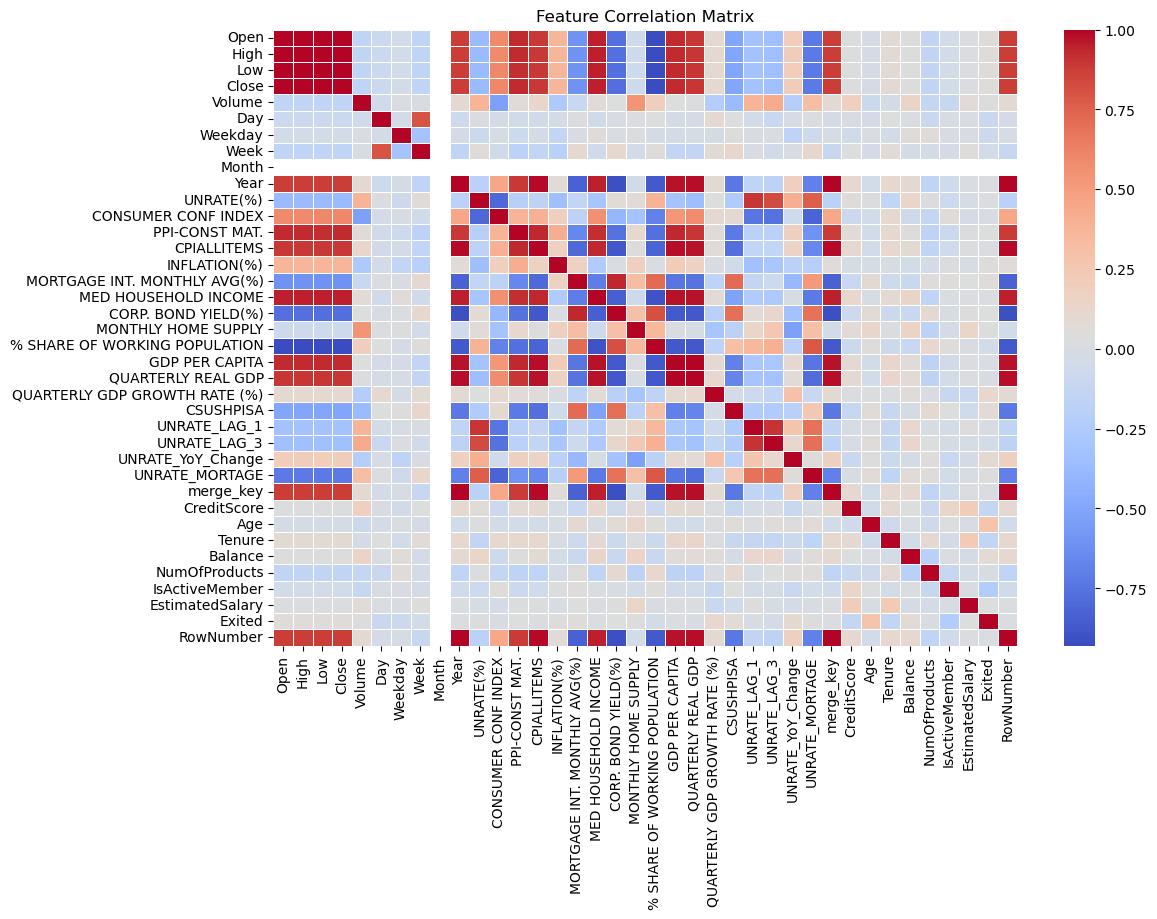

Correlation with Target Variable:
Exited                           1.000000
Age                              0.280783
QUARTERLY GDP GROWTH RATE (%)    0.113058
UNRATE_YoY_Change                0.100572
Balance                          0.076077
CSUSHPISA                        0.071166
High                             0.052861
Close                            0.051501
Low                              0.051452
MORTGAGE INT. MONTHLY AVG(%)     0.051204
Open                             0.051147
INFLATION(%)                     0.048778
Volume                           0.042177
MONTHLY HOME SUPPLY              0.040609
UNRATE_MORTAGE                   0.039149
EstimatedSalary                  0.032094
CORP. BOND YIELD(%)              0.031978
PPI-CONST MAT.                   0.030791
CPIALLITEMS                      0.016058
UNRATE(%)                        0.014856
Year                             0.013572
MED HOUSEHOLD INCOME             0.011238
GDP PER CAPITA                   0.011061


In [729]:
# Select only numeric columns
numeric_data = merged_data.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numeric_data.corr()

# Plot the heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.show()

# Optional: Display correlations with the target variable (e.g., 'Exited')
if 'Exited' in numeric_data.columns:
    target_correlation = correlation_matrix['Exited'].sort_values(ascending=False)
    print("Correlation with Target Variable:")
    print(target_correlation)


In [669]:
model = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')
model.fit(X_train_scaled, y_train)
# Use the best parameters
model = LogisticRegression(C=0.01, solver='liblinear', max_iter=1000, random_state=42)
model.fit(X_train_scaled, y_train)


LogisticRegression(C=0.01, max_iter=1000, random_state=42, solver='liblinear')

In [682]:
# Check if X and y are defined
print(X.shape)  # Should show (rows, features)
print(y.shape)  # Should show (rows,)


(152, 39)
(152,)


In [686]:
print(X.select_dtypes(include=['object']).columns)


Index(['Geography', 'Gender'], dtype='object')


In [702]:
print(X.columns)
encoded_columns = [col for col in X.columns if col.startswith('Geography') or col.startswith('Gender')]
print("Encoded Columns:", encoded_columns)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Weekday', 'Week',
       'Month', 'Year', 'UNRATE(%)', 'CONSUMER CONF INDEX', 'PPI-CONST MAT.',
       'CPIALLITEMS', 'INFLATION(%)', 'MORTGAGE INT. MONTHLY AVG(%)',
       'MED HOUSEHOLD INCOME', 'CORP. BOND YIELD(%)', 'MONTHLY HOME SUPPLY',
       '% SHARE OF WORKING POPULATION', 'GDP PER CAPITA', 'QUARTERLY REAL GDP',
       'QUARTERLY GDP GROWTH RATE (%)', 'CSUSHPISA', 'UNRATE_LAG_1',
       'UNRATE_LAG_3', 'UNRATE_YoY_Change', 'UNRATE_MORTAGE', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'Tenure_Buckets', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')
Encoded Columns: ['Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [710]:
print(X.columns)
X['Geography'] = final_merged_data['Geography']
X['Gender'] = final_merged_data['Gender']




Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Weekday', 'Week',
       'Month', 'Year', 'UNRATE(%)', 'CONSUMER CONF INDEX', 'PPI-CONST MAT.',
       'CPIALLITEMS', 'INFLATION(%)', 'MORTGAGE INT. MONTHLY AVG(%)',
       'MED HOUSEHOLD INCOME', 'CORP. BOND YIELD(%)', 'MONTHLY HOME SUPPLY',
       '% SHARE OF WORKING POPULATION', 'GDP PER CAPITA', 'QUARTERLY REAL GDP',
       'QUARTERLY GDP GROWTH RATE (%)', 'CSUSHPISA', 'UNRATE_LAG_1',
       'UNRATE_LAG_3', 'UNRATE_YoY_Change', 'UNRATE_MORTAGE', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'Tenure_Buckets', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')


In [721]:
X = X.loc[:, ~X.columns.duplicated()]
print(X.columns)
print(X.filter(regex='Geography|Gender').head())


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Weekday', 'Week',
       'Month', 'Year', 'UNRATE(%)', 'CONSUMER CONF INDEX', 'PPI-CONST MAT.',
       'CPIALLITEMS', 'INFLATION(%)', 'MORTGAGE INT. MONTHLY AVG(%)',
       'MED HOUSEHOLD INCOME', 'CORP. BOND YIELD(%)', 'MONTHLY HOME SUPPLY',
       '% SHARE OF WORKING POPULATION', 'GDP PER CAPITA', 'QUARTERLY REAL GDP',
       'QUARTERLY GDP GROWTH RATE (%)', 'CSUSHPISA', 'UNRATE_LAG_1',
       'UNRATE_LAG_3', 'UNRATE_YoY_Change', 'UNRATE_MORTAGE', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'Tenure_Buckets', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')
   Geography_Germany  Geography_Spain  Gender_Male
0              False            False        False
1              False             True        False
2              False            False        False
3              False            False        False
4         

In [727]:
X = X.drop(columns=['Geography_Germany', 'Geography_Spain', 'Gender_Male'], errors='ignore')
if 'Geography' in X.columns and 'Gender' in X.columns:
    X = pd.get_dummies(X, columns=['Geography', 'Gender'], drop_first=True)
print(X.columns)


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Day', 'Weekday', 'Week',
       'Month', 'Year', 'UNRATE(%)', 'CONSUMER CONF INDEX', 'PPI-CONST MAT.',
       'CPIALLITEMS', 'INFLATION(%)', 'MORTGAGE INT. MONTHLY AVG(%)',
       'MED HOUSEHOLD INCOME', 'CORP. BOND YIELD(%)', 'MONTHLY HOME SUPPLY',
       '% SHARE OF WORKING POPULATION', 'GDP PER CAPITA', 'QUARTERLY REAL GDP',
       'QUARTERLY GDP GROWTH RATE (%)', 'CSUSHPISA', 'UNRATE_LAG_1',
       'UNRATE_LAG_3', 'UNRATE_YoY_Change', 'UNRATE_MORTAGE', 'CreditScore',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'IsActiveMember',
       'EstimatedSalary', 'Exited', 'Tenure_Buckets'],
      dtype='object')


In [745]:
print(X.select_dtypes(include=['object', 'category']).columns)
from sklearn.preprocessing import LabelEncoder

if 'Tenure_Buckets' in X.columns:
    encoder = LabelEncoder()
    X['Tenure_Buckets'] = encoder.fit_transform(X['Tenure_Buckets'])
print(X.select_dtypes(include=['object', 'category']).columns)


Index([], dtype='object')
Index([], dtype='object')


In [749]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns=['Exited'], errors='ignore'))
y = X['Exited']


In [758]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [776]:
import numpy as np

print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())

# Replace NaNs in X_train
col_mean = np.nanmean(X_train, axis=0)
X_train = np.where(np.isnan(X_train), col_mean, X_train)

# Replace NaNs in X_test
col_mean_test = np.nanmean(X_test, axis=0)
X_test = np.where(np.isnan(X_test), col_mean_test, X_test)

# Replace NaNs with 0
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)

print("Any NaN in X_train:", np.isnan(X_train).any())
print("Any NaN in X_test:", np.isnan(X_test).any())


Missing values in X_train: 0
Missing values in X_test: 0
Any NaN in X_train: False
Any NaN in X_test: False


In [778]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)


In [780]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Confusion Matrix:
 [[23  3]
 [ 5  0]]
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.88      0.85        26
           1       0.00      0.00      0.00         5

    accuracy                           0.74        31
   macro avg       0.41      0.44      0.43        31
weighted avg       0.69      0.74      0.71        31

Accuracy: 0.7419354838709677


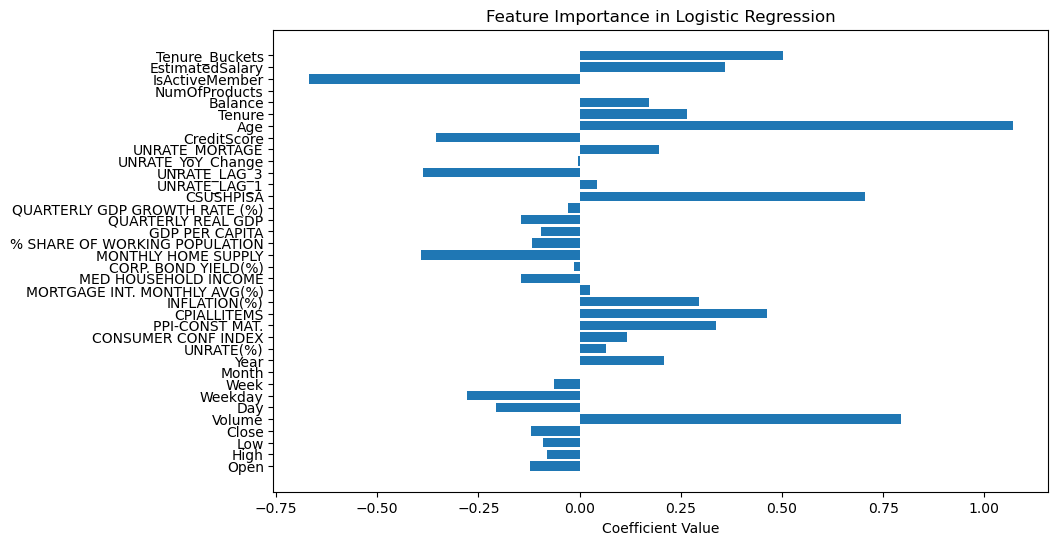

In [782]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance
feature_importance = model.coef_[0]
feature_names = X.drop(columns=['Exited'], errors='ignore').columns

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel("Coefficient Value")
plt.title("Feature Importance in Logistic Regression")
plt.show()


In [784]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {scores}")
print(f"Mean Cross-Validation Score: {np.mean(scores)}")


Cross-Validation Scores: [0.72       0.70833333 0.79166667 0.75       0.625     ]
Mean Cross-Validation Score: 0.719


In [786]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 0.7849999999999999


In [792]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Assuming X is your feature matrix

# Split the scaled data
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


In [794]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define the model
rf_model = RandomForestClassifier(random_state=42)

# Define hyperparameters
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Perform Grid Search
rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy')
rf_grid.fit(X_train_scaled, y_train)

# Get the best parameters and score
print("Best Parameters for Random Forest:", rf_grid.best_params_)
print("Best Cross-Validation Accuracy for Random Forest:", rf_grid.best_score_)

# Make predictions
rf_best = rf_grid.best_estimator_
y_pred_rf = rf_best.predict(X_test_scaled)

# Evaluate the model
print("Random Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))


Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Accuracy for Random Forest: 1.0
Random Forest Confusion Matrix:
 [[26  0]
 [ 0  5]]
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00         5

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Random Forest Test Accuracy: 1.0


In [804]:
from sklearn.impute import SimpleImputer

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can choose 'median' or 'most_frequent'
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)  # Apply the same imputation to the test set


In [807]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Define the model
gb_model = GradientBoostingClassifier(random_state=42)

# Define hyperparameters
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10]
}

# Perform Grid Search
gb_grid = GridSearchCV(gb_model, gb_param_grid, cv=5, scoring='accuracy')
gb_grid.fit(X_train_scaled, y_train)

# Get the best parameters and score
print("Best Parameters for Gradient Boosting:", gb_grid.best_params_)
print("Best Cross-Validation Accuracy for Gradient Boosting:", gb_grid.best_score_)

# Make predictions
gb_best = gb_grid.best_estimator_
y_pred_gb = gb_best.predict(X_test_scaled)

# Evaluate the model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print("Gradient Boosting Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))
print("Gradient Boosting Classification Report:\n", classification_report(y_test, y_pred_gb))
print("Gradient Boosting Test Accuracy:", accuracy_score(y_test, y_pred_gb))


Best Parameters for Gradient Boosting: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Best Cross-Validation Accuracy for Gradient Boosting: 1.0
Gradient Boosting Confusion Matrix:
 [[26  0]
 [ 0  5]]
Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       1.00      1.00      1.00         5

    accuracy                           1.00        31
   macro avg       1.00      1.00      1.00        31
weighted avg       1.00      1.00      1.00        31

Gradient Boosting Test Accuracy: 1.0


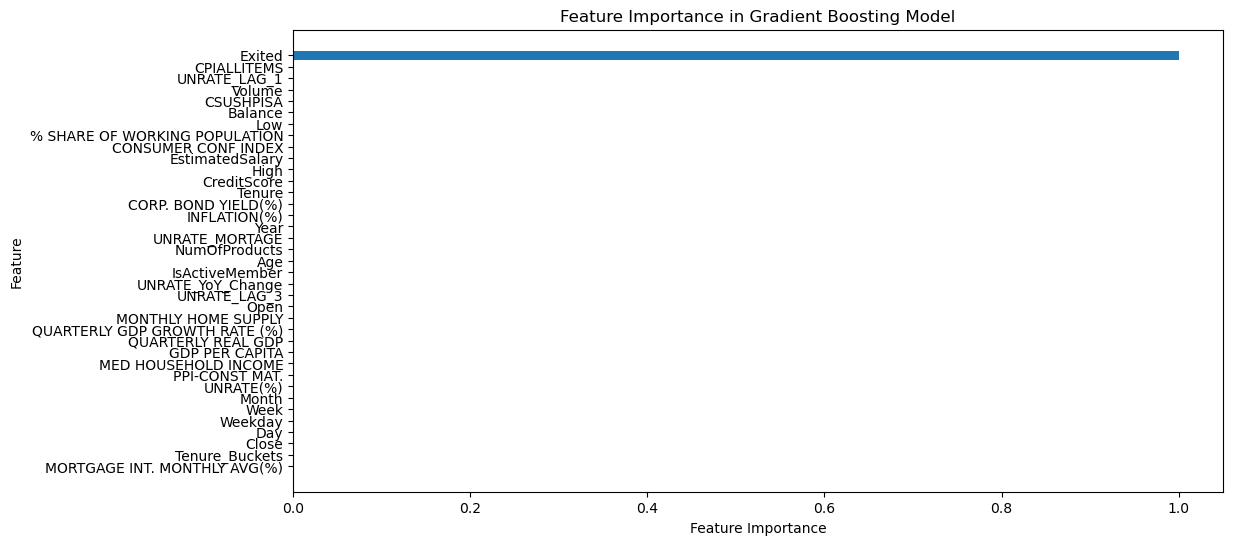

In [809]:
import matplotlib.pyplot as plt
import pandas as pd

feature_importance = gb_best.feature_importances_
feature_names = X.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Gradient Boosting Model')
plt.gca().invert_yaxis()
plt.show()


In [811]:
misclassified = X_test_scaled[y_test != y_pred_gb]
print("Misclassified Examples:\n", misclassified)


Misclassified Examples:
 []


In [848]:
import numpy as np
print("Missing values in X_scaled:", np.isnan(X_scaled).sum())
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # Use 'median' if more appropriate
X_scaled = imputer.fit_transform(X_scaled)

imputer = SimpleImputer(strategy='most_frequent')
X_scaled = imputer.fit_transform(X_scaled)

print("Missing values after imputation:", np.isnan(X_scaled).sum())


Missing values in X_scaled: 0
Missing values after imputation: 0


In [850]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(gb_best, X_scaled, y, cv=10, scoring='accuracy')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())


Cross-Validation Scores: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Mean CV Accuracy: 1.0


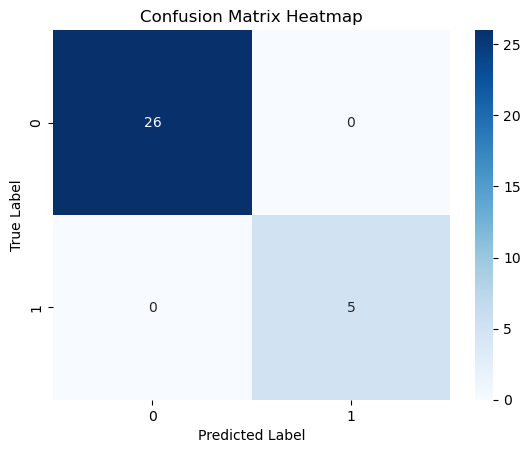

In [855]:
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()


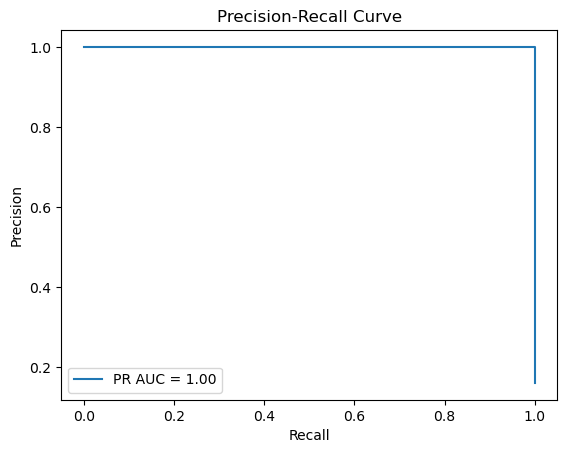

In [857]:
from sklearn.metrics import precision_recall_curve, auc

y_probs = gb_best.predict_proba(X_test_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [863]:
pip install shap

   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ------ --------------------------------- 71.7/456.2 kB 1.3 MB/s eta 0:00:01
   ------------------- -------------------- 225.3/456.2 kB 2.3 MB/s eta 0:00:01
   ------------------------------------ --- 419.8/456.2 kB 2.9 MB/s eta 0:00:01
   ---------------------------------------- 456.2/456.2 kB 2.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


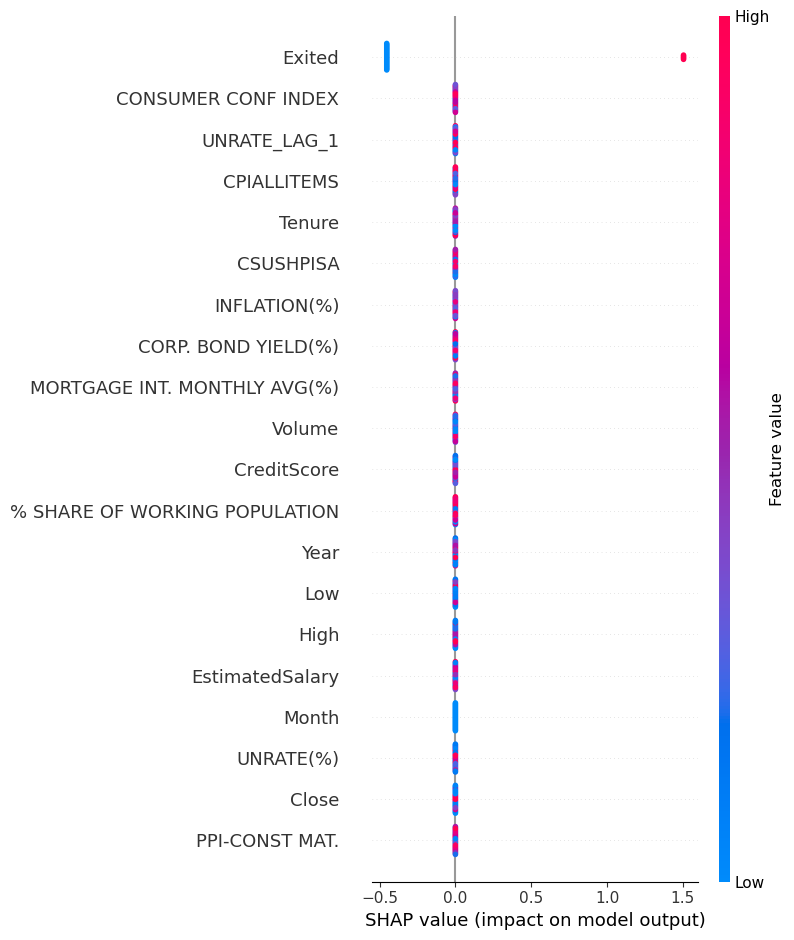

IndexError: index 1 is out of bounds for axis 0 with size 1

In [868]:
import shap

explainer = shap.TreeExplainer(gb_best)
shap_values = explainer.shap_values(X_test_scaled)

# Summary plot
shap.summary_plot(shap_values, X_test_scaled, feature_names=X.columns)

# Force plot for a single instance
shap.force_plot(explainer.expected_value[1], shap_values[2][0], X_test_scaled[0], feature_names=X.columns)
